In [16]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


import mpmath
import networkx as nx

from metal.label_model import LabelModel, LabelModelInd
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data

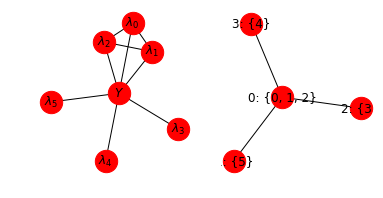

In [50]:
M = 6
N = 10000
MAX_CLIQUE_SIZE = 3
NUM_CLIQUES = 1
K = 2
HIGHER_ORDER_CLIQUES = False

# Set Graph Structure
EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
deps_graph = DependenciesGraph(M, EDGES)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()


#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    param_ranges={
            "theta_acc_range": (0.1, 1),
            "theta_edge_range": (0.1, 1),
        },
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
plt.subplot(1,2,2)
data.jt.draw()

#get true values for later comparison, label model
sigma_O = data.get_sigma_O()
class_balance = data.get_class_balance()

L, Y = data.generate_label_matrix(N)

## Visualize Inverse Sigma_O

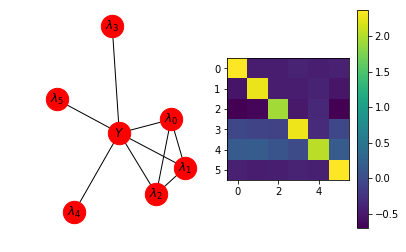

In [51]:
import copy

L_conflict = 2*(L-1.5) #1,2 to -1,1
Y_conflict = 2*(Y-1.5) #1,2 to -1,1

O = np.dot(L_conflict.T,L)/(N-1)
accuracies = np.array([np.mean(L_conflict[:,i] == Y_conflict) for i in range(M)])
mu_from_acc = 2*accuracies - 1
    
    
sig = O - np.outer(mu_from_acc,mu_from_acc)
sig_inv = np.linalg.pinv(sig)

J_clean = copy.deepcopy(sig_inv)
for i in range(sig_inv.shape[0]):
    for j in range(sig_inv.shape[1]):
        if abs(sig_inv[i,j]) < 0.2:
            J_clean[i,j] = 0
        else:
            J_clean[i,j] = sig_inv[i,j]

plt.subplot(1,2,1)
deps_graph.draw()

plt.subplot(1,2,2)
plt.imshow(sig_inv)
plt.colorbar()